Stefan Pophristic + Boxuan Li

Hypothetical Mandarin

$$F_{\beta} = I_{q}(N; W) + \beta E_{n,w}[d(N,N_{w})]$$

Both the compression term and the reconstruction term are dependent on $q(w)$ and $q(w|n)$

$$I_q(N; W) = \sum_n p(n) \sum_w q(w \mid n) \log \frac{q(w \mid n)}{q(w)}$$
$E_{x,w}[d(x,x_w)]=\sum_{w}​q(w∣N)d(x,x_{w}​)$


To quantify $q(w)$ and $q(w|n)$ we will be using the Blahut-Arimoto Algorithm:
- Instead of initialize a random distribution for q(w), we will define d(V, Vn) as the cosine distance matrix between N and W
- Then using Gibb's equation, we will calculate q(w|n)
- and then iterate until convergence


$$q(w|n) = \frac{q(w)e^{-\beta d(V_{w}, V_{N})}}{\sum_{w} q(w')e^{-\beta d(V_{w}, V_{N})}}$$

$$q(w) = \sum_{N} \hat{p}(n)q(w|n)$$


# Import variables and packages

In [2]:
import os
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast

from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import normalize


/var/folders/0f/7mr42p3n3mxc5z1g5q3267p81ryl0h/T/ipykernel_47933/570069863.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [100]:
noun_semantics_df = pd.read_pickle("output/noun_semantics.pkl")
mw_semantics_df = pd.read_pickle("output/mw_semantics.pkl")

In [101]:

def filter_valid_vectors(df, column_name, expected_shape=(300,), label=""):
    original_len = len(df)
    is_valid = df[column_name].apply(
        lambda x: isinstance(x, (list, np.ndarray)) and np.array(x).shape == expected_shape
    )
    filtered_df = df[is_valid].reset_index(drop=True)
    dropped = original_len - len(filtered_df)
    if dropped > 0:
        print(f"{dropped} {label} rows dropped due to invalid or malformed vectors.")
    return filtered_df

# Filter both DataFrames with proper reporting
noun_semantics_df = filter_valid_vectors(noun_semantics_df, 'noun_semantics', label="nouns")
mw_semantics_df = filter_valid_vectors(mw_semantics_df, 'MW_centroid', label="MWs")


7 nouns rows dropped due to invalid or malformed vectors.


In [103]:
noun_semantics_df = noun_semantics_df.drop_duplicates(subset=["noun"])
mw_semantics_df = mw_semantics_df.drop_duplicates(subset=["MW"])

In [104]:
noun_semantics_df.head()

,noun,count,noun_semantics
0,上午,1,"[0.0198, -0.0406, 0.4887, -0.0755, -0.038, 0.1..."
1,下半,1,"[0.0306, 0.0379, 0.4806, 0.0162, 0.1408, -0.12..."
2,下旬,3,"[0.1047, -0.0735, 0.5682, 0.056, 0.0032, -0.05..."
3,下颌,1,"[0.3003, -0.3533, 0.2598, -0.1818, 0.2832, -0...."
4,专辑,6,"[-0.186, -0.0423, 0.4913, 0.1851, 0.0968, -0.0..."


In [105]:
mw_semantics_df.head(100)

,MW,Count_Pre,MW_centroid,mw_semantics
0,日,1,"[0.0308, -0.023712497, 0.4776, -0.028487498, -...","[0.1245, -0.0269, 0.4524, 0.1575, 0.01, -0.048..."
1,局,1,"[0.0306, 0.0379, 0.4806, 0.0162, 0.1408, -0.12...","[0.1245, -0.0269, 0.4524, 0.1575, 0.01, -0.048..."
2,年,1,"[0.016535418, 0.040139582, 0.51436454, -0.0627...","[0.1245, -0.0269, 0.4524, 0.1575, 0.01, -0.048..."
3,月,2,"[0.057184614, 0.03014615, 0.4474923, -0.003700...","[0.1245, -0.0269, 0.4524, 0.1575, 0.01, -0.048..."
4,个,1,"[-0.006889136, 0.022415332, 0.46960655, -0.039...","[0.1245, -0.0269, 0.4524, 0.1575, 0.01, -0.048..."
...,...,...,...,...
612,台,1,"[0.0030999994, -0.060374998, 0.513875, 0.00197...","[0.1245, -0.0269, 0.4524, 0.1575, 0.01, -0.048..."
623,方,1,"[0.0497, 0.2007, 0.641, -0.3201, 0.0088, -0.19...","[0.1245, -0.0269, 0.4524, 0.1575, 0.01, -0.048..."
666,夸脱,2,"[-0.1965, 0.0625, 0.3719, -0.1342, -0.0421, 0....","[0.1245, -0.0269, 0.4524, 0.1575, 0.01, -0.048..."
677,连串,1,"[-0.024, 0.0726, 0.517, 0.036, -0.1434, -0.034...","[0.1245, -0.0269, 0.4524, 0.1575, 0.01, -0.048..."


In [107]:
print(mw_semantics_df.shape[0])
print(noun_semantics_df.shape[0])

110
840


# Blahut-Arimoto Algorithm

## Initialize first w x n dataframe and q_n

In [140]:

# Extract nouns and classifier names
nouns = noun_semantics_df['noun'].values
mws = mw_semantics_df['MW'].values

# Stack vectors into matrices
noun_vectors = np.vstack(noun_semantics_df['noun_semantics'].values)
mw_vectors = np.vstack(mw_semantics_df['mw_semantics'].values)

noun_vectors = normalize(noun_vectors, axis=1)
mw_vectors = normalize(mw_vectors, axis=1)
    
# Compute cosine distance matrix (W x N)
distance_matrix = cosine_distances(mw_vectors, noun_vectors)  # shape: (W, N)

# Optional: Put in DataFrame for clarity
distance_df = pd.DataFrame(distance_matrix, index=mws, columns=nouns)

# Rescale distance matrix
distance_matrix = (distance_matrix - distance_matrix.min()) / (distance_matrix.max() - distance_matrix.min())


In [141]:
# q_n = np.log1p(noun_semantics_df['count'])  # log(x+1) transformation
# q_n /= np.sum(q_n)

In [142]:
# q_n = noun_semantics_df['count'].values.astype(float)

# # Currently our q_n is very small, and the noramlization results in 0 values, so let's scale it all up
# epsilon = 1e-10  # very small value
# q_n = np.clip(q_n, epsilon, 1.0)  # ensure q_n doesn't go to zero

# q_n /= np.sum(q_n)  # Normalize so that the sum of q(n) is 1


In [143]:
noun_semantics_df['count'] = noun_semantics_df['count'].replace(0, 1)
q_n = np.log1p(noun_semantics_df['count'])  # log(x+1) transformation
q_n /= np.sum(q_n)  # Normalize so that sum(q_n) = 1

In [144]:
np.any(q_n == 0)


False

## Define BA functions

To calculate convergence: 

$$\Delta = \left\| q^{(t)}(w \mid n) - q^{(t-1)}(w \mid n) \right\|$$

Whereby we check the difference between this iterations q(w|n) value and the previous one. We want this Delta to be negligible change, i.e. more iterations of the BA algorithm won't really gain us anything

We will use a strict tolerance of $\Delta < 10^06$


In [145]:
'''
Checks whether q(w|n) value has converged, i.e. whether difference in values is less than 10^-6

input: two matrices to compare

output: true or false
'''

def check_convergence(q_w_n, prev_q_w_n): 
    if prev_q_w_n is None:
        return False  # First iteration, no previous value to compare to
     
    delta = np.linalg.norm(q_w_n - prev_q_w_n)
    
    return delta < threshold

In [164]:
'''
beta = beta value
q_w = q(w)
q_n = q(n)
iter_index = iteration index
q_w_n = q(w|n). If not defined (i.e. first iteration) use the initialized value computed above

output:
- q_w values
- q_w_n values
- converge: true if converged, false if not
'''

def blahut_arimoto_iteration(beta, q_w = None, q_w_n = None, iter = 0):

    if iter > iter_max:
        print("Exceeded maximum iterations without reaching convergence")
        return(q_w, q_w_n, False)

    #save current state of q_w_n to use for convergence check
    prev_q_w_n = q_w_n

    # if we are on the first iteration, save prev_q_w_n as none AND calculate first distance
    if iter == 0:
        prev_q_w_n = None

    
        ###
        # Initialize first q_w_n
        ###
        
        # Apply the exponentiation with the beta parameter
        exp_distance_matrix = np.exp(-beta * distance_matrix)
        
        # Normalize by summing over each row (for each noun n)
        q_w_n = exp_distance_matrix / exp_distance_matrix.sum(axis=0, keepdims=True)
    
    ###########
    # Calculate q(w) marginal
    ###########

    # Step 2: Calculate q(w) (marginal over n)
    q_w = np.sum(q_w_n, axis=1)
    
    # Normalize q(w) so that it sums to 1
    q_w /= np.sum(q_w) # (q_w = q_w / np.sum(q_w)) 
    
    # Check if q(w) sums to 1
    # print("Sum of q(w):", np.sum(q_w))  # This should print 1
    # print(q_w.shape) # should print (1006,)

    ###########
    # Update q(w|n)
    ###########

    # Numerator: q(w)[:, None] * exp(-beta * d(w, n))
    numerator = q_w[:, np.newaxis] * np.exp(-beta * distance_matrix)

    # Denominator: sum over w for each n (i.e., column-wise)
    denominator = np.sum(numerator, axis=0, keepdims=True)
    # print(distance_matrix.shape)
    

    # Normalize to get q(w|n)
    q_w_n = numerator / denominator
    # assert np.allclose(np.sum(q_w_n, axis=0), 1.0)

    
    # print(np.sum(q_w_n, axis=0))  # should be close to an array of 1s

    ###########
    # Check Convergence
    ###########

    # if converged, end
    if check_convergence(q_w_n, prev_q_w_n):
        return(q_w, q_w_n, True)
    # Otherwise, continue to next iteration
    else:
        iter+= 1
        return blahut_arimoto_iteration(beta, q_w, q_w_n, iter) 

    


## Define RDT Function


$$F_{\beta} = I_{q}(N; W) + \beta E_{n,w}[d(N,N_{w})]$$

Both the compression term and the reconstruction term are dependent on $q(w)$ and $q(w|n)$

$$I_q(N; W) = \sum_n p(n) \sum_w q(w \mid n) \log \frac{q(w \mid n)}{q(w)}$$
$$E_{x,w}[d(x,x_w)]=\sum_{w}​q(w∣N)d(x,x_{w}​)$$


In [165]:
# '''
# take in a q(w), q(w|n), and beta

# Calcualte the compression versus distortion trade off 
# '''

# def calc_RDT(beta, q_w, q_w_n, q_n):

#     ###########
#     # Calculate Iq(w; n)
#     ###########

#     # print("Any zeros in q_w:", np.any(q_w == 0))
#     # print("Any zeros in q_n:", np.any(q_n == 0))
    
#     # Step 1: Calculate the term inside the log function
#     # q(w|n) / (q(w) * q(n)) for each combination of n and w
#     # log_term = np.log(q_w_n / (q_w[:, np.newaxis] * np.array(q_n)[np.newaxis, :]))

#     # print(f"log_term Min: {np.min(log_term)}")
#     # print(f"log_term Max: {np.max(log_term)}")
#     # print(f"log_term Mean: {np.mean(log_term)}")

#     # # Step 2: Compute mutual information I_q(N; W)
#     # complexity_term = np.sum(q_w_n * log_term)

#     q_n = np.array(q_n)

#     q_w_n = q_w_n.T      # shape (N, W) — now consistent
    
#     q_n_w = q_n[:, np.newaxis] * q_w_n  # shape (N, W)
#     log_term = np.log(q_w_n / q_w[np.newaxis, :])  # shape (N, W)
    
#     complexity_term = np.sum(q_n_w * log_term)  # scalar

#     # Print the result for I_q
#     # print("Mutual Information I_q(N; W):", complexity_term)

#      ###########
#     # Calculate E(distortion)
#     ###########

#     distortion_term = np.sum(q_w_n * distance_df.values)  # q(w|n) * d(n, w)
    
#     # Step 2: Calculate the expected value of the distortion term: E[n,w][d(n, w)] with q(n)
#     expected_distortion_term = np.sum(q_w_n * distance_df.values * np.array(q_n)[np.newaxis, :])

#     # Print the expected distortion term
#     # print("Expected Distortion Term:", expected_distortion_term)

#     return(complexity_term, expected_distortion_term)

In [166]:
def calc_RDT(beta, q_w, q_w_n, q_n):
    q_n = np.array(q_n)  # shape: (N,)
    eps = 1e-12

    # Mutual information I(N;W)
    log_term = np.log((q_w_n + eps) / (q_w[:, np.newaxis] + eps))  # shape: (W, N)
    complexity_term = np.sum(q_w_n * log_term * q_n[np.newaxis, :])  # shape: scalar

    # Expected distortion E[d(w,n)]
    expected_distortion_term = np.sum(q_w_n * distance_matrix * q_n[np.newaxis, :])

    # assert q_w_n.shape == distance_matrix.shape == (110, 840)
    # assert q_n.shape == (840,)

    return complexity_term, expected_distortion_term


## Run BA Algorithm

In [172]:
threshold = 1e-6
iter_max = 2500

beta_val = []
complexity_val = []
dist_val = []
convergence = []

betas = np.logspace(np.log10(1), np.log10(115), num=5)
betas = range(1, 20)

for beta in betas: 

    print(f"Enter Iteration #{beta}")
    
    BA_output = blahut_arimoto_iteration(beta)
    
    q_w = BA_output[0]
    print("Min q_w:", q_w.min())

    q_w_n = BA_output[1]
    converge = BA_output[2]

    # print(q_w)
    
    RDT_output = calc_RDT(beta, q_w, q_w_n, q_n)
    
    complexity = RDT_output[0]
    distortion = RDT_output[1]

    beta_val.append(beta)
    complexity_val.append(complexity)
    dist_val.append(distortion)
    convergence.append(converge)

Enter Iteration #1
Exceeded maximum iterations without reaching convergence
Min q_w: 0.009090911
Enter Iteration #2
Min q_w: 0.009090908
Enter Iteration #3
Min q_w: 0.009090911
Enter Iteration #4
Min q_w: 0.009090908
Enter Iteration #5
Min q_w: 0.009090911
Enter Iteration #6
Min q_w: 0.009090911
Enter Iteration #7
Exceeded maximum iterations without reaching convergence
Min q_w: 0.009090908
Enter Iteration #8
Min q_w: 0.009090908
Enter Iteration #9
Min q_w: 0.009090908
Enter Iteration #10
Min q_w: 0.009090908
Enter Iteration #11
Exceeded maximum iterations without reaching convergence
Min q_w: 0.009090908
Enter Iteration #12
Min q_w: 0.009090908
Enter Iteration #13
Min q_w: 0.009090909
Enter Iteration #14
Min q_w: 0.00909091
Enter Iteration #15
Min q_w: 0.00909091
Enter Iteration #16
Min q_w: 0.009090908
Enter Iteration #17
Min q_w: 0.009090911
Enter Iteration #18
Min q_w: 0.009090909
Enter Iteration #19
Min q_w: 0.00909091


In [173]:
print("Distance matrix min/max:", distance_matrix.min(), distance_matrix.max())


Distance matrix min/max: 0.0 1.0


In [174]:
# print("q_w_n sums (columns):", np.sum(q_w_n, axis=0))  # Should be all ~1
print("q_w sum:", np.sum(q_w))                         # Should be ~1
print("min q_w:", q_w.min())                           # Should be >0
print("min/max distance:", distance_matrix.min(), distance_matrix.max())
print("complexity value:", complexity)                 # Should be ≥ 0
print("distortion value:", distortion)                 # Should be > 0 and not tiny


q_w sum: 0.99999994
min q_w: 0.00909091
min/max distance: 0.0 1.0
complexity value: -1.3241679862742994e-07
distortion value: 0.6768645755572928


In [175]:
df = pd.DataFrame({
    'beta': beta_val,
    'complexity': complexity_val,
    'distortion': dist_val,
    'convergence': convergence
})

In [176]:
q_w.shape

(110,)

In [177]:
df.head(10)

,beta,complexity,distortion,convergence
0,1,-1.555970e-07,0.676865,False
1,2,1.306239e-07,0.676865,True
2,3,-1.833621e-07,0.676865,True
3,4,1.699259e-07,0.676865,True
4,5,-2.054550e-07,0.676865,True
5,6,-2.087205e-07,0.676865,True
6,7,1.238674e-07,0.676865,False
7,8,1.581998e-07,0.676865,True
8,9,1.652239e-07,0.676865,True
9,10,1.677529e-07,0.676865,True


In [178]:
# Subset rows where convergence is True
df_converged = df[df['convergence'] == True]

# Display the resulting dataframe
print(df_converged)

    beta    complexity  distortion  convergence
1      2  1.306239e-07    0.676865         True
2      3 -1.833621e-07    0.676865         True
3      4  1.699259e-07    0.676865         True
4      5 -2.054550e-07    0.676865         True
5      6 -2.087205e-07    0.676865         True
7      8  1.581998e-07    0.676865         True
8      9  1.652239e-07    0.676865         True
9     10  1.677529e-07    0.676865         True
11    12  1.692453e-07    0.676865         True
12    13 -3.479111e-08    0.676865         True
13    14 -1.233729e-07    0.676865         True
14    15 -1.638985e-07    0.676865         True
15    16  1.579374e-07    0.676865         True
16    17 -2.371365e-07    0.676865         True
17    18 -7.152488e-08    0.676865         True
18    19 -1.324168e-07    0.676865         True


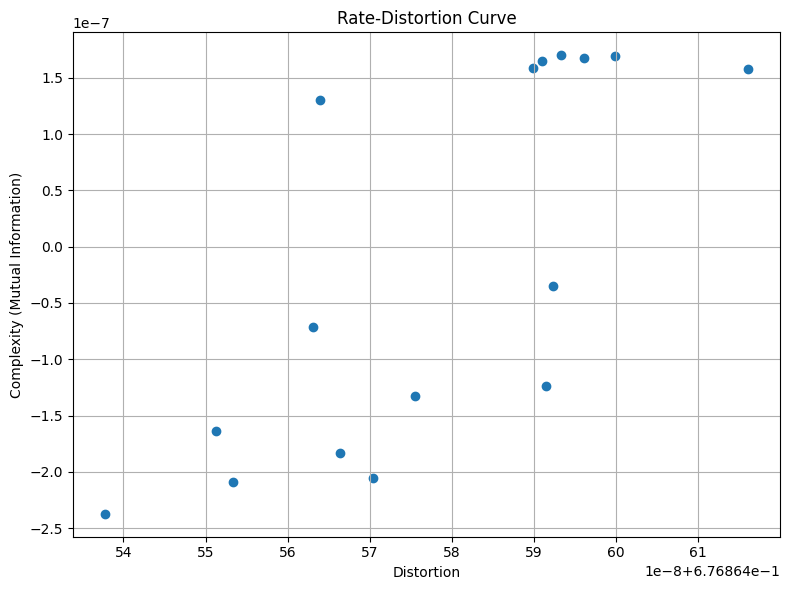

In [179]:
plt.figure(figsize=(8, 6))
plt.scatter(df_converged['distortion'], df_converged['complexity'], marker='o')
plt.xlabel('Distortion')
plt.ylabel('Complexity (Mutual Information)')
plt.title('Rate-Distortion Curve')
plt.grid(True)
plt.tight_layout()
plt.show()

. What Do q(n) and q(w) Represent in Your Model?
q(n): Empirical distribution over nouns. This should reflect how likely each noun is to occur in your corpus.

q(w): Marginal distribution over classifiers (MWs) implied by q(w|n) and q(n).

If you only have 1–2 occurrences per noun, then:

Your estimate of q(n) is extremely noisy (essentially uniform with small fluctuations).

Downstream calculations (e.g., expected distortion, mutual information) depend on q(n) as a weight.

Rare items contribute disproportionately when small sample sizes introduce noise, not signal.

This means:

The mutual information could be low or unstable because q(w|n) isn’t informative — either because it’s not learned well or because the true q(n) lacks contrast.